### Imports and Libraries

In [1]:
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix 

### Collect image paths and load images

In [2]:
# Function to collect image paths
def collect_image_paths(directory):
    paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
    return paths

# Collect image paths
path1 = collect_image_paths('C:/Users/Tharindu/Desktop/Research Project/Alzheimer MRI scan _ Alzheimer disease/Non Demented')
path2 = collect_image_paths('C:/Users/Tharindu/Desktop/Research Project/Alzheimer MRI scan _ Alzheimer disease/Mild Dementia')
path3 = collect_image_paths('C:/Users/Tharindu/Desktop/Research Project/Alzheimer MRI scan _ Alzheimer disease/Moderate Dementia')
path4 = collect_image_paths('C:/Users/Tharindu/Desktop/Research Project/Alzheimer MRI scan _ Alzheimer disease/Very mild Dementia')

# Set the size of the sample
size = 400  

# Set seed for reproducibility
random.seed(42)

# Sample random paths
sample_path1 = random.sample(path1, min(size, len(path1)))
sample_path2 = random.sample(path2, min(size, len(path2)))
sample_path3 = random.sample(path3, min(size, len(path3)))
sample_path4 = random.sample(path4, min(size, len(path4)))

# Output the sample sizes
print(f'Sampled {len(sample_path1)} paths from Non Demented')
print(f'Sampled {len(sample_path2)} paths from Mild Dementia')
print(f'Sampled {len(sample_path3)} paths from Moderate Dementia')
print(f'Sampled {len(sample_path4)} paths from Very mild Dementia')

Sampled 400 paths from Non Demented
Sampled 400 paths from Mild Dementia
Sampled 400 paths from Moderate Dementia
Sampled 400 paths from Very mild Dementia


### Data preprocessing and splitting

In [3]:
# Initialize the encoder
encoder = OneHotEncoder()

# Fit the encoder on your categorical data
encoder.fit([[0], [1], [2], [3]])

# 0 --> Non Demented
# 1 --> Mild Dementia
# 2 --> Moderate Dementia
# 3 --> Very Mild Dementia

OneHotEncoder()

In [4]:
# Function to load images and labels
data = []
result = []
def load_images(sample_paths, label):
    for path in sample_paths:
        img = Image.open(path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        if img.shape == (128, 128, 3):
            data.append(img)
            result.append(encoder.transform([[label]]).toarray())

# Load images and labels
load_images(sample_path1, 0)  # Non Demented
load_images(sample_path2, 1)  # Mild Dementia
load_images(sample_path3, 2)  # Moderate Dementia
load_images(sample_path4, 3)  # Very Mild Dementia

In [5]:
# Convert data and result to numpy arrays
data = np.array(data)
result = np.array(result).reshape((1600, 4))
data.shape
result.shape

(1600, 4)

In [6]:
# Split the data into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(data,result,test_size=0.15,shuffle=True,random_state=42)

### Model creation using EfficientNetV2B0.

In [7]:
# Load the pre-trained EfficientNetV2 model without the top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # Assuming 4 classes

# Create the new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images by 20 degrees
    zoom_range=0.2,             # Randomly zoom into images by 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill newly created pixels with the nearest pixel value
)

datagen.fit(x_train)

### Model training

In [ ]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=10),
    validation_data=(x_test, y_test),
    epochs=20
)

C:\Users\THARINDU\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 31/136 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - accuracy: 0.3521 - loss: 1.4505

### Save the model

In [ ]:
# Save the model
model.save('Alzheimers_model.h5')

### Plotting training and validation accuracy and loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
                    precision    recall  f1-score   support

      Non Demented       0.82      0.74      0.77        72
     Mild Dementia       0.78      0.56      0.65        62
 Moderate Dementia       0.83      0.96      0.89        57
Very Mild Dementia       0.52      0.67      0.58        49

          accuracy                           0.73       240
         macro avg       0.74      0.73      0.73       240
      weighted avg       0.75      0.73      0.73       240



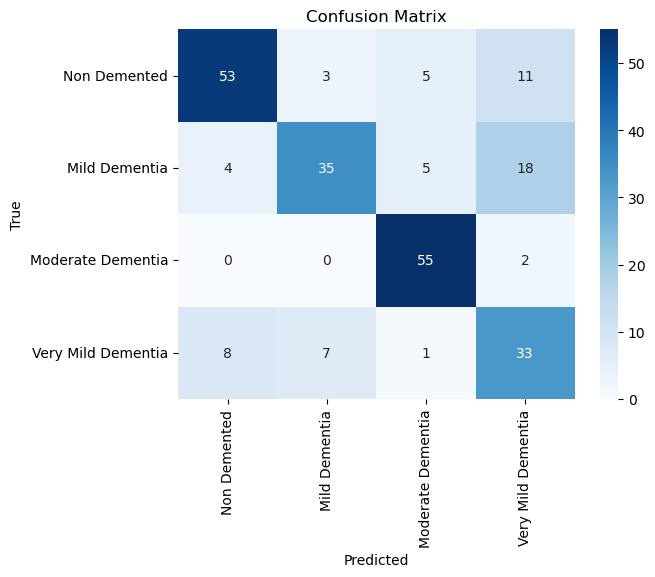

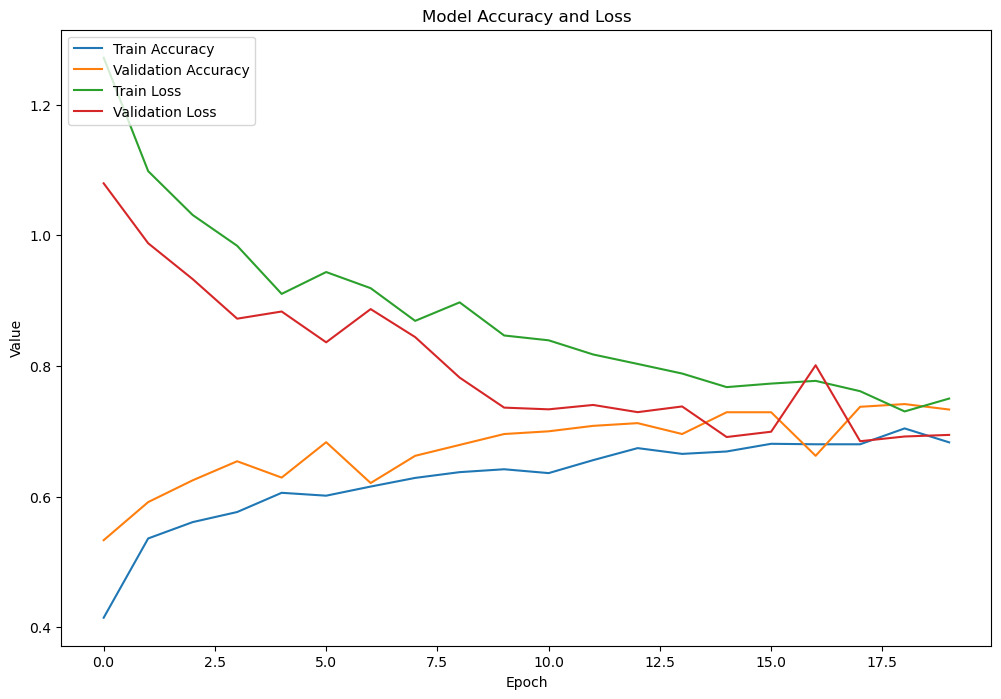

In [ ]:
# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia'], yticklabels=['Non Demented', 'Mild Dementia', 'Moderate Dementia', 'Very Mild Dementia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy and loss values in one graph
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Function to map prediction to class name
def names(number):
    if number == 0:
        return 'Non Demented'
    elif number == 1:
        return 'Mild Dementia'
    elif number == 2:
        return 'Moderate Dementia'
    elif number == 3:
        return 'Very Mild Dementia'
    else:
        return 'Error in Prediction'


78.60260009765625% Confidence This Is Moderate Dementia


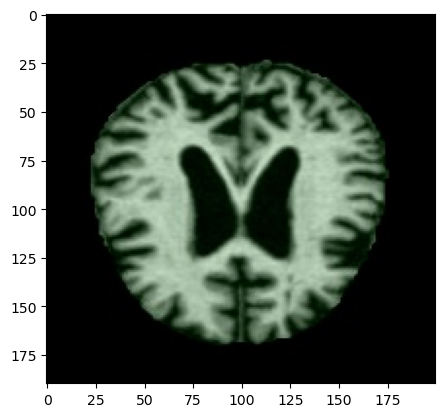

In [ ]:
# Predict and visualize a sample image
from matplotlib.pyplot import imshow
img = Image.open(r'C:/Users/Tharindu/Desktop/Research Project/Alzheimer MRI scan _ Alzheimer disease/Mild Dementia/MI (13).jpg')
img = img.convert('RGB') 
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res=model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100)+ '% Confidence This Is '+ names(classification))